# Time series forecasting 

* tensorflow/docs/site/en/tutorials/structured_data/[time_series.ipynb](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb)
* Commit `e51ebb4` on May 9, 2022, [compare](https://github.com/tensorflow/docs/compare/e51ebb4..).

In [1]:
import os
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

* 14 features (air temperature, atmospheric pressure, and humidity)
* Collected every 10 minutes (use hourly predictions)

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path = os.path.splitext(zip_path)[0]
csv_path

'/home/eavelar/.keras/datasets/jena_climate_2009_2016.csv'

In [3]:
df = pd.read_csv(csv_path)
df = df[5::6] 

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


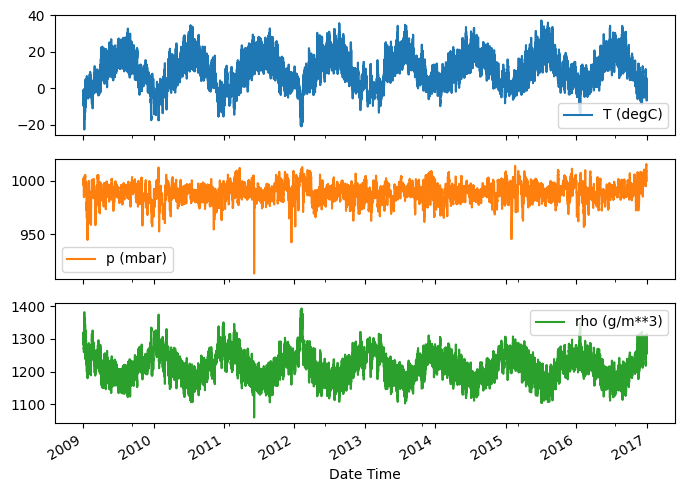

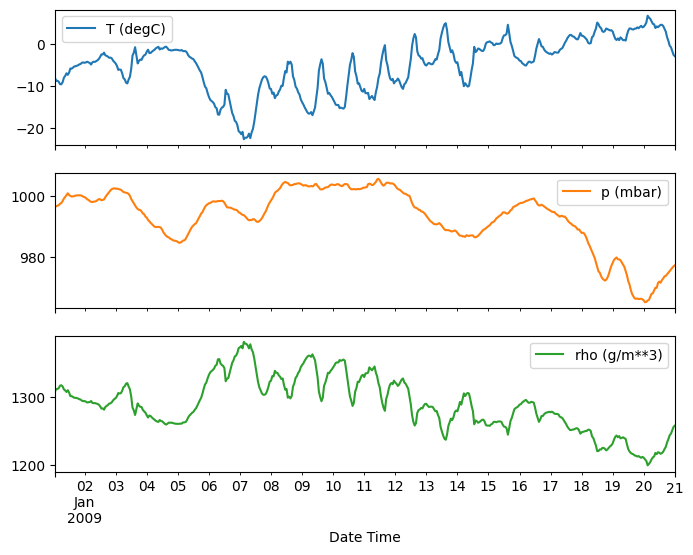

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


`-9999` is likely erroneous, replace it with zeros.

In [7]:
wv = df['wv (m/s)']
wv[wv == -9999.0] = 0.0

max_wv = df['max. wv (m/s)']
max_wv[max_wv == -9999.0] = 0.0

df['wv (m/s)'].min()

0.0

### Feature engineering

Text(0, 0.5, 'Wind Velocity [m/s]')

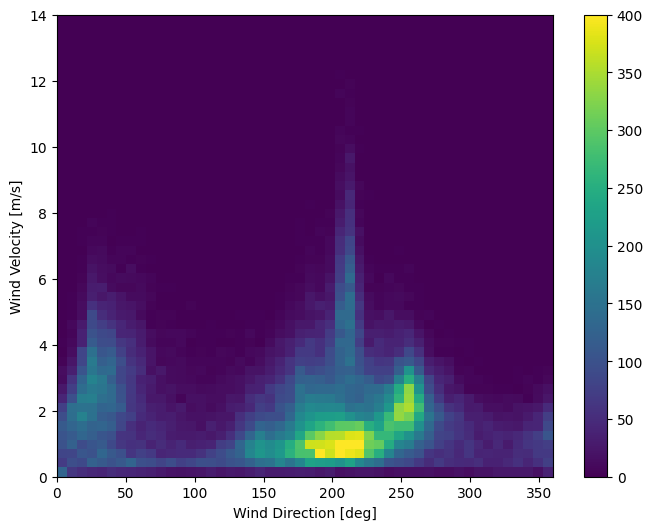

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Convert the wind direction and velocity columns to a wind **vector**

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

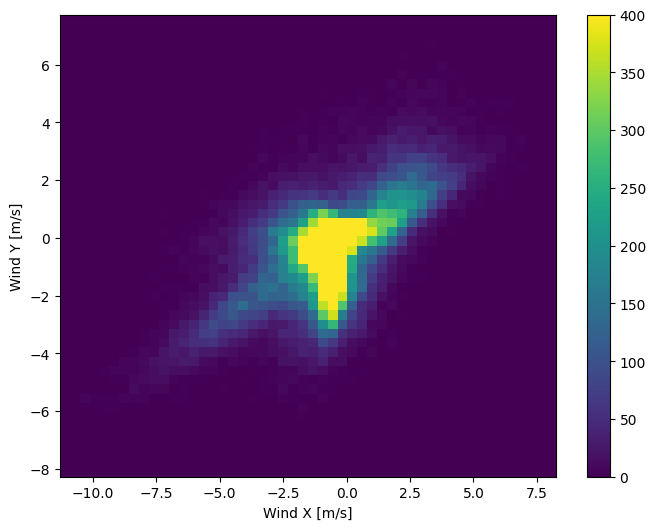

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [12]:
day = 60*60*24
year = 365.2425 * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

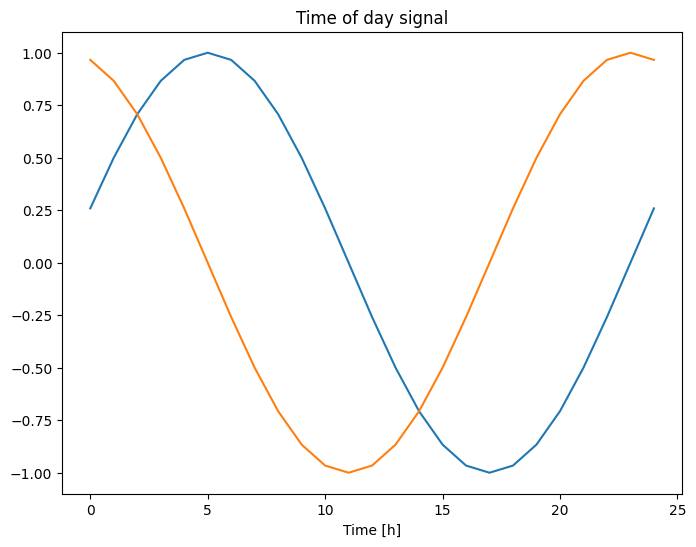

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

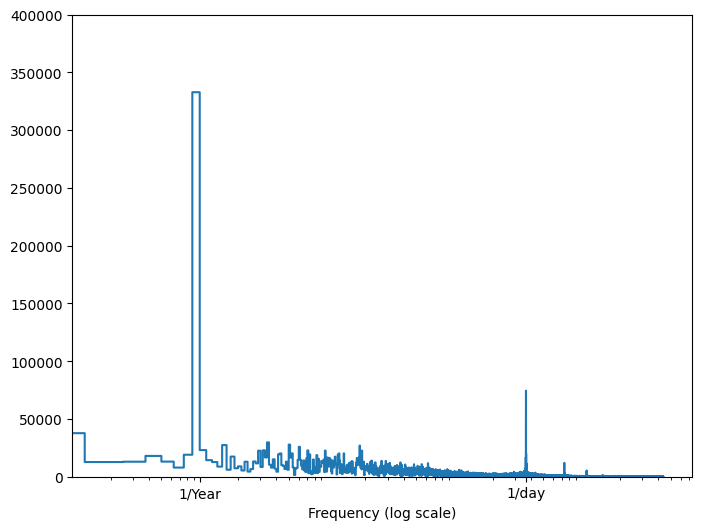

In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split data

training -> `70%`, validation -> `20%`, test -> `10%`

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_limit = int(n*0.7)
val_limit = int(n*0.9)

train_df = df[:train_limit]
val_df = df[train_limit:val_limit]
test_df = df[val_limit:]

num_features = df.shape[1]

### Normalize data

* this normalization should be done using moving averages (in the interest of simplicity this tutorial uses a simple average)

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

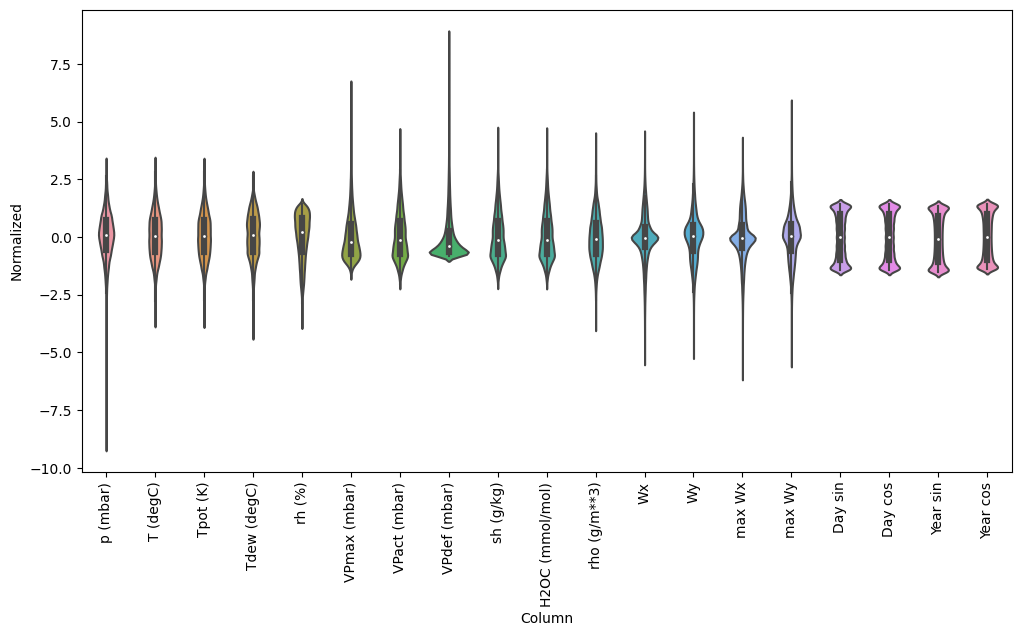

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

In [18]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                    train_df=train_df, val_df=val_df, test_df=test_df, 
                    label_columns=None):
        
        self.train_df=train_df
        self.val_df=val_df
        self.test_df=test_df

        # Work out the label columns indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### Split

In [21]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


The innermost indices are the features.

In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

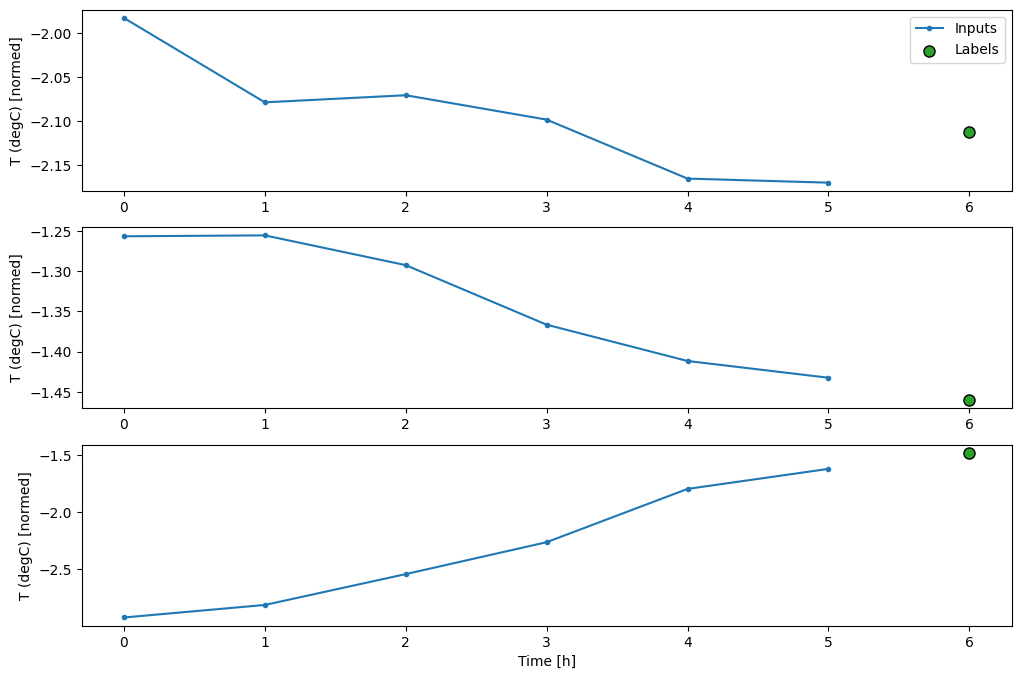

In [25]:
w2.plot()

### Create `tf.data.Dataset`s

In [26]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [28]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [29]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

In [30]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [31]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly.

In [32]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [33]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


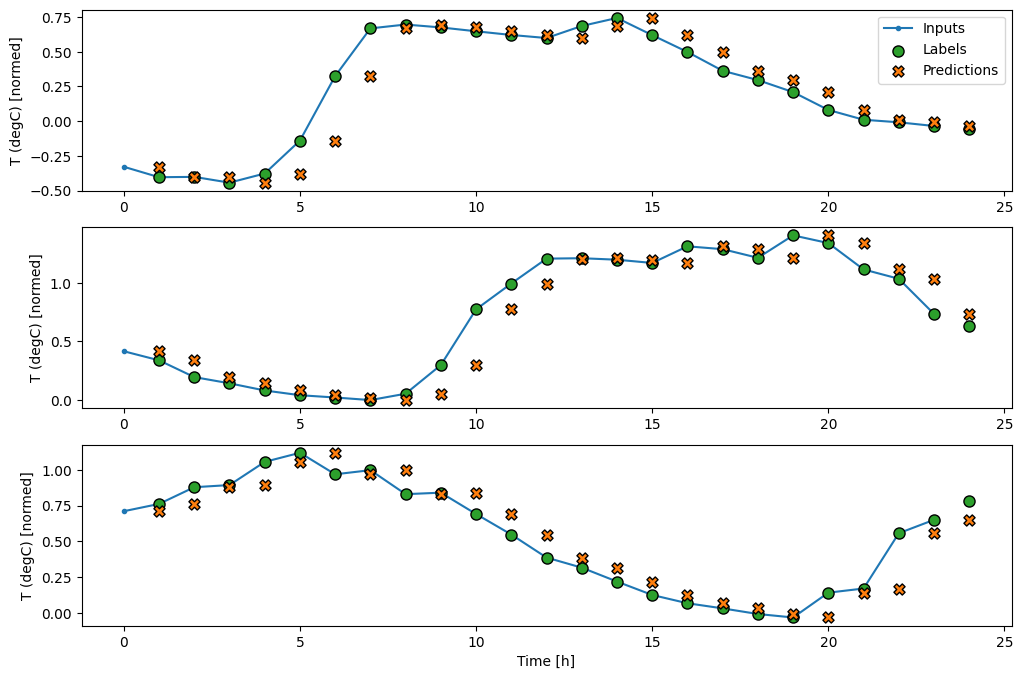

In [36]:
wide_window.plot(baseline)

### Linear model

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model.

In [37]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [38]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [39]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=tf.keras.metrics.MeanAbsoluteError())
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history

In [40]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 14s 8ms/step - loss: 0.0548 - mean_absolute_error: 0.1522 - val_loss: 0.0117 - val_mean_absolute_error: 0.0789
Epoch 2/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0102 - mean_absolute_error: 0.0743 - val_loss: 0.0091 - val_mean_absolute_error: 0.0698
Epoch 3/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0094 - mean_absolute_error: 0.0711 - val_loss: 0.0088 - val_mean_absolute_error: 0.0692
Epoch 4/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0088 - val_mean_absolute_error: 0.0686
Epoch 5/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0086 - val_mean_absolute_error: 0.0680
Epoch 6/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0089 - val_mean_absolute_error: 0.069

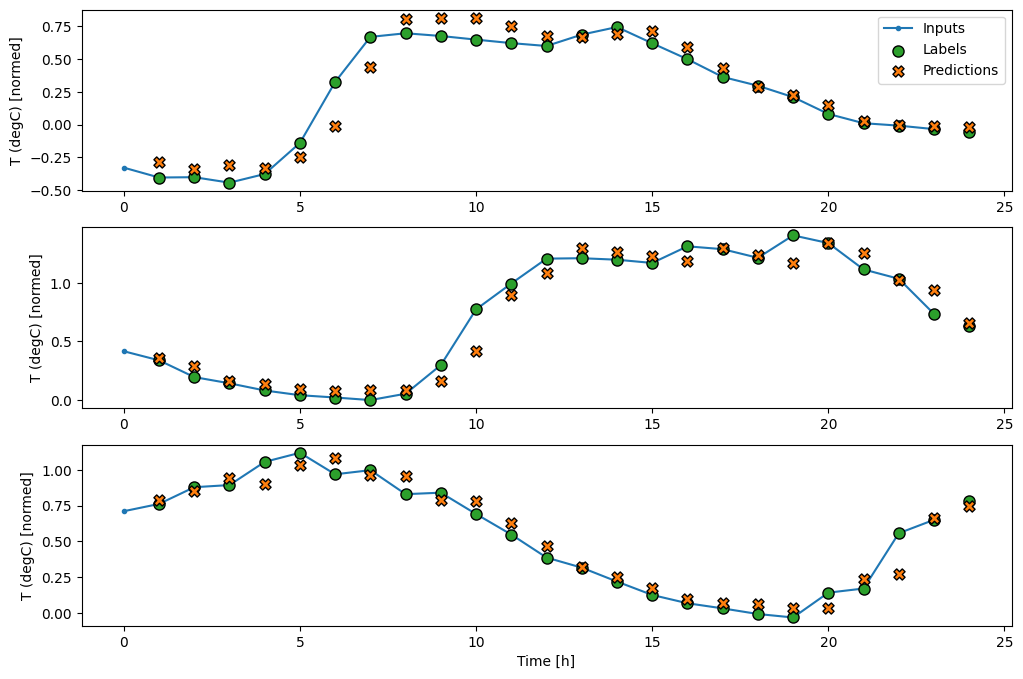

In [41]:
wide_window.plot(linear)

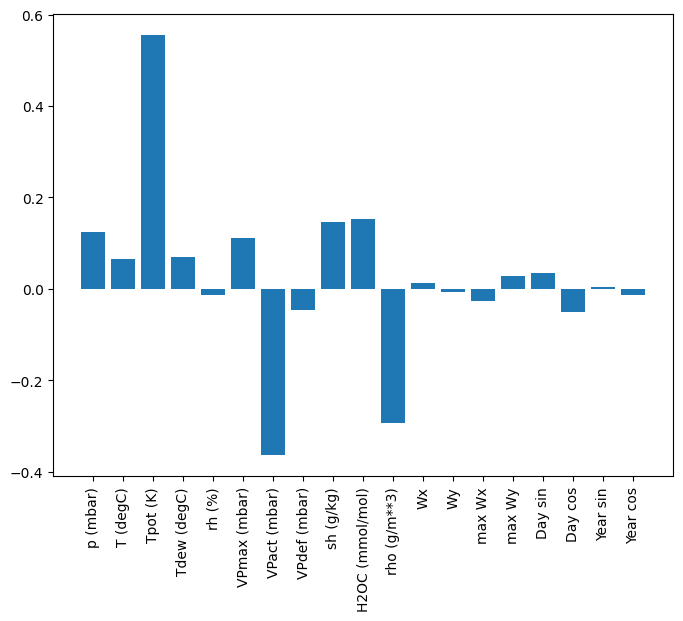

In [42]:
plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the output `T (degC)`. This is one of the risks of random initialization.

### Dense

In [43]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
1534/1534 [==============================] - 21s 12ms/step - loss: 0.0144 - mean_absolute_error: 0.0778 - val_loss: 0.0075 - val_mean_absolute_error: 0.0622
Epoch 2/20
1534/1534 [==============================] - 19s 12ms/step - loss: 0.0077 - mean_absolute_error: 0.0635 - val_loss: 0.0069 - val_mean_absolute_error: 0.0584
Epoch 3/20
1534/1534 [==============================] - 20s 13ms/step - loss: 0.0074 - mean_absolute_error: 0.0619 - val_loss: 0.0068 - val_mean_absolute_error: 0.0571
Epoch 4/20
1534/1534 [==============================] - 18s 12ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0069 - val_mean_absolute_error: 0.0578
Epoch 5/20
439/439 [==============================] - 4s 8ms/step - loss: 0.0070 - mean_absolute_error: 0.0590


### Multi-step dense

In [44]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=3,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future')

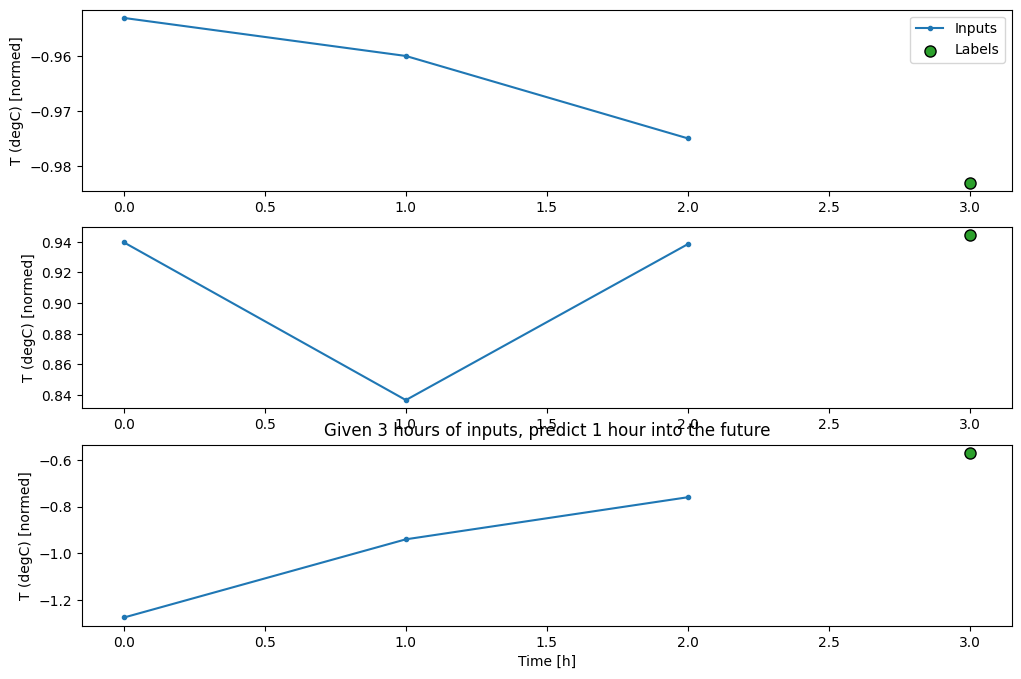

In [45]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model.

In [46]:
multi_step_dense = tf.keras.Sequential([
    # (batch, time, features) => (batch, time*features)
    tf.keras.layers.Flatten(),
    # (batch, time*features) =>
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
    # Add back the time dimension
    # (batch, 1) => 
    tf.keras.layers.Reshape([1, -1])
    # (batch, 1, 1)
])

In [47]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [48]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0066 - mean_absolute_error: 0.0565


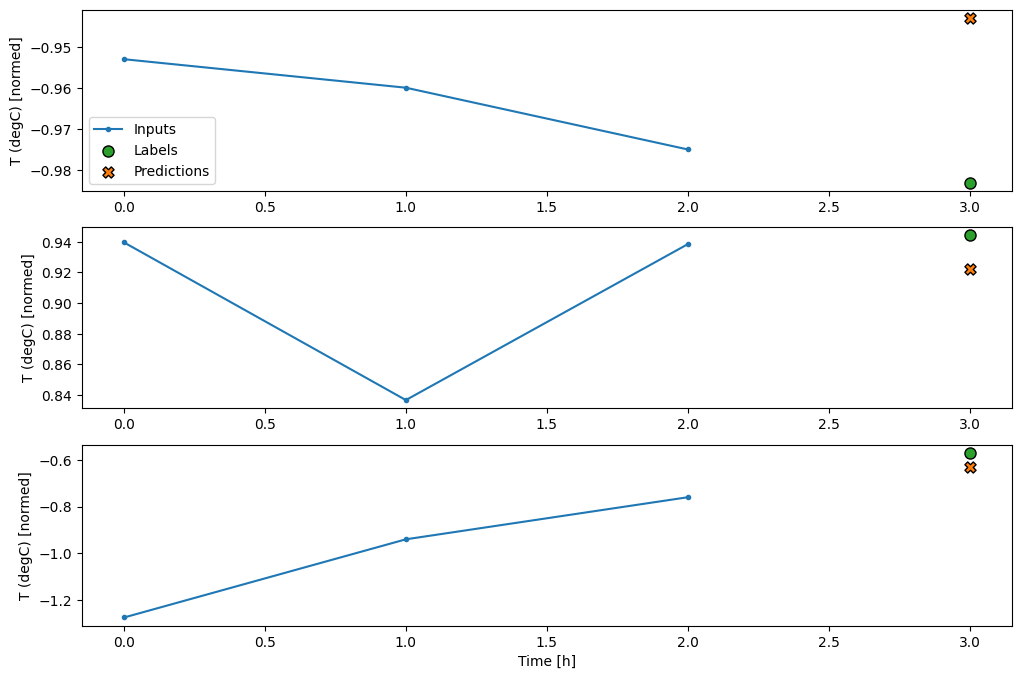

In [49]:
conv_window.plot(multi_step_dense)

### Convolution neural network

In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, CONV_WIDTH, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [51]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 4s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0559


In [53]:
print('Wide window')
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [54]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [55]:
print('Wide conv window')
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels window:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels window: (32, 24, 1)
Output shape: (32, 24, 1)


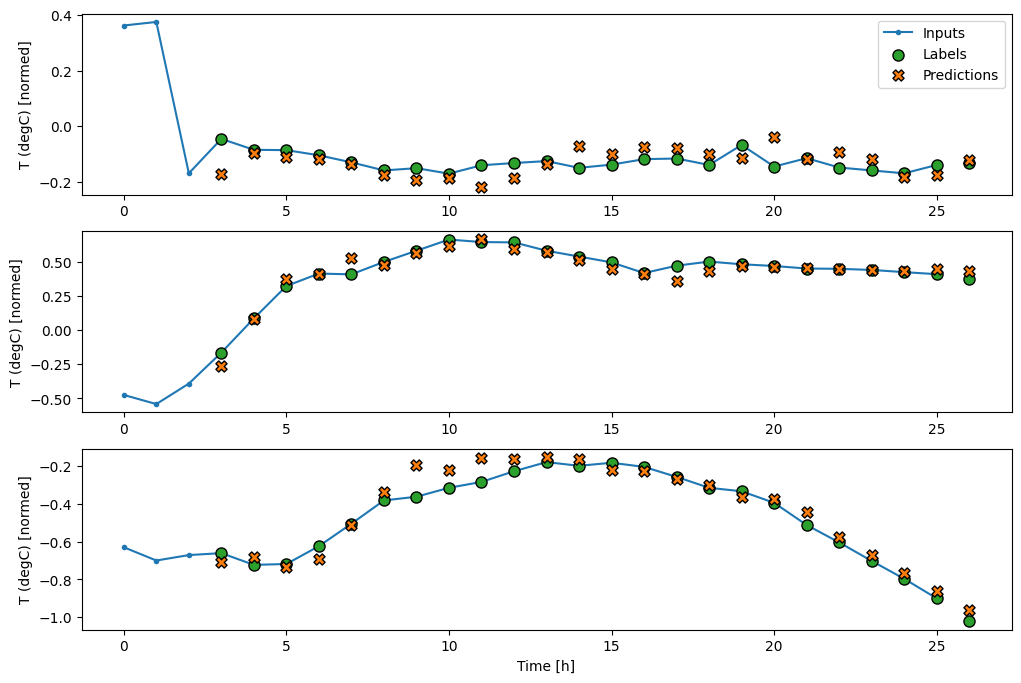

In [56]:
wide_conv_window.plot(conv_model)

### Recurrent neural networks

`return_sequences` argument:
* Stacking RNN layers
* Training a model on multiple time steps simultaneously

In [57]:
lstm_model = tf.keras.Sequential([
    # (batch, time, features) =>
    tf.keras.layers.LSTM(32, return_sequences=True), 
    # (batch, time, 32) =>
    tf.keras.layers.Dense(1) 
    # (batch, time, 1)
])

In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [59]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0516


### Performance

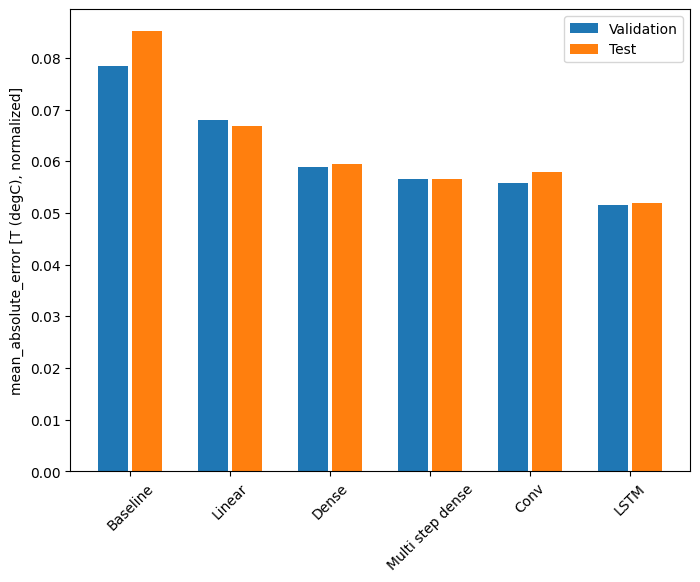

In [60]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [61]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0669
Dense       : 0.0596
Multi step dense: 0.0566
Conv        : 0.0579
LSTM        : 0.0519


### Multi-output models

In [62]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


#### Baseline

In [63]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [64]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [65]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_features)
])

In [66]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 4s 9ms/step - loss: 0.0683 - mean_absolute_error: 0.1309


#### RNN

In [67]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 9ms/step - loss: 0.0615 - mean_absolute_error: 0.1198


#### Advanced: Residual Connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step.

In [68]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        return inputs + delta

In [69]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(num_features, kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.1180


#### Performance

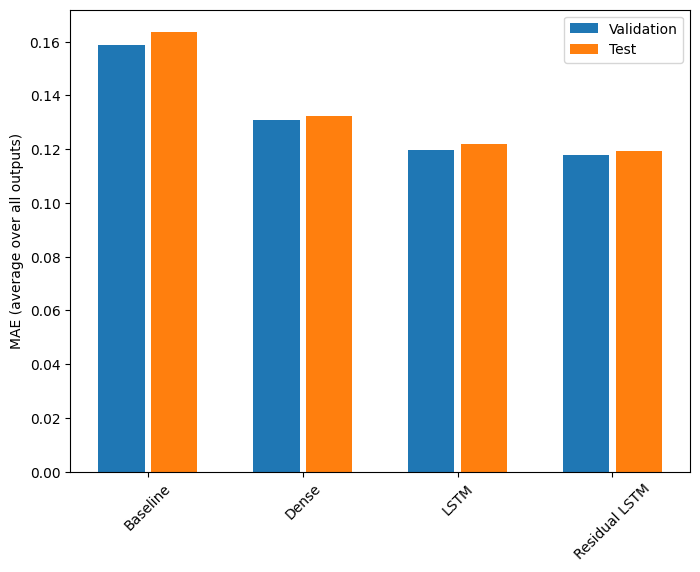

In [70]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [71]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1324
LSTM           : 0.1219
Residual LSTM  : 0.1195


## Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

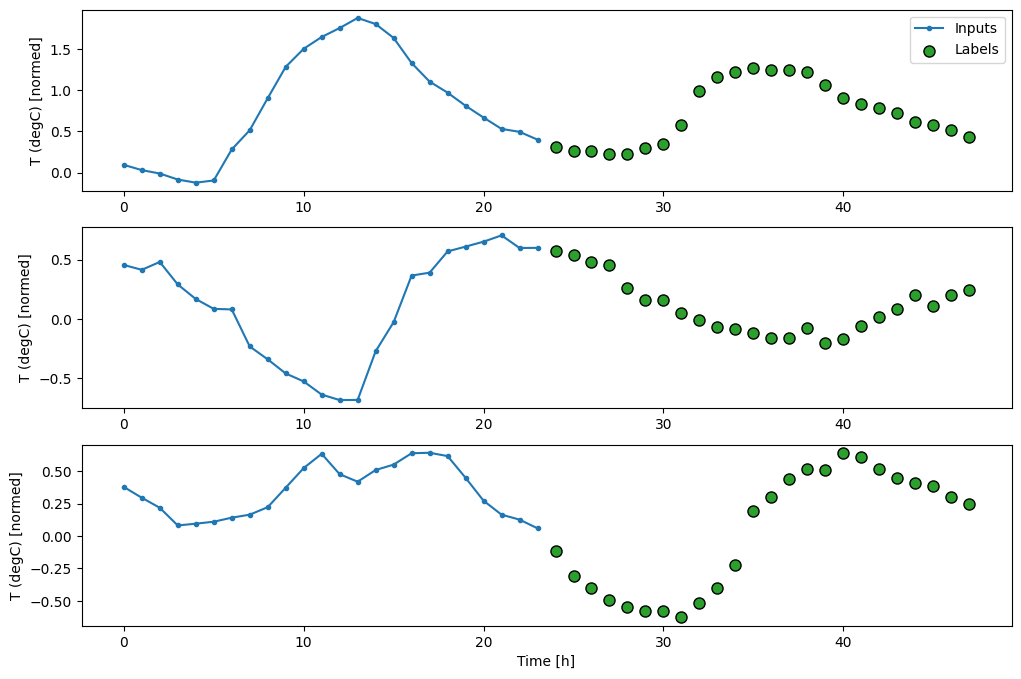

In [72]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

437/437 [==============================] - 2s 5ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


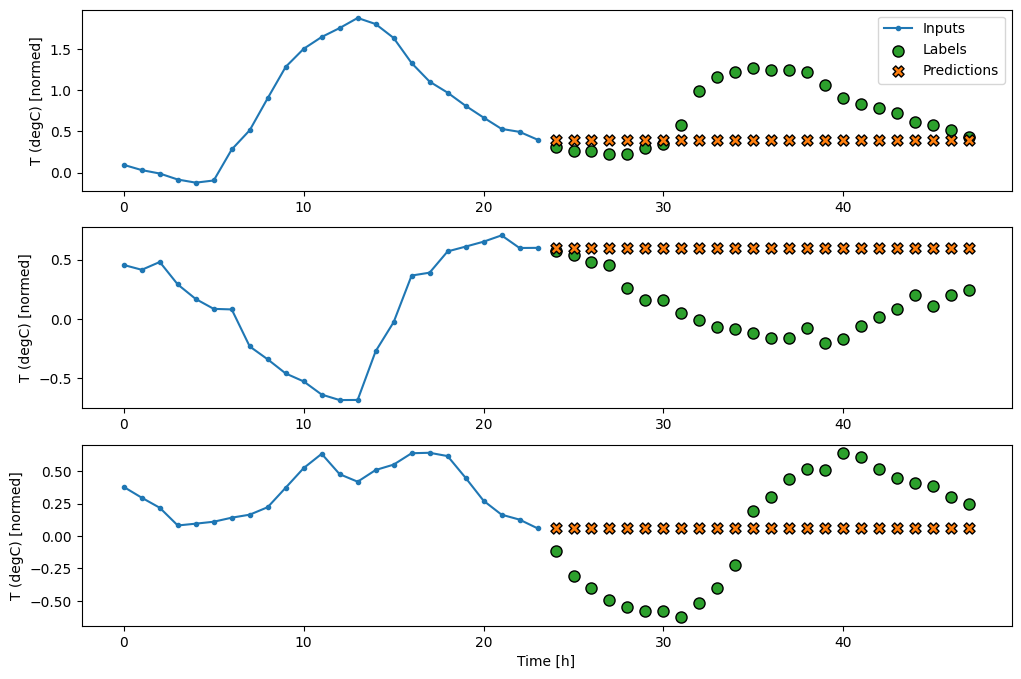

In [73]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

437/437 [==============================] - 2s 5ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


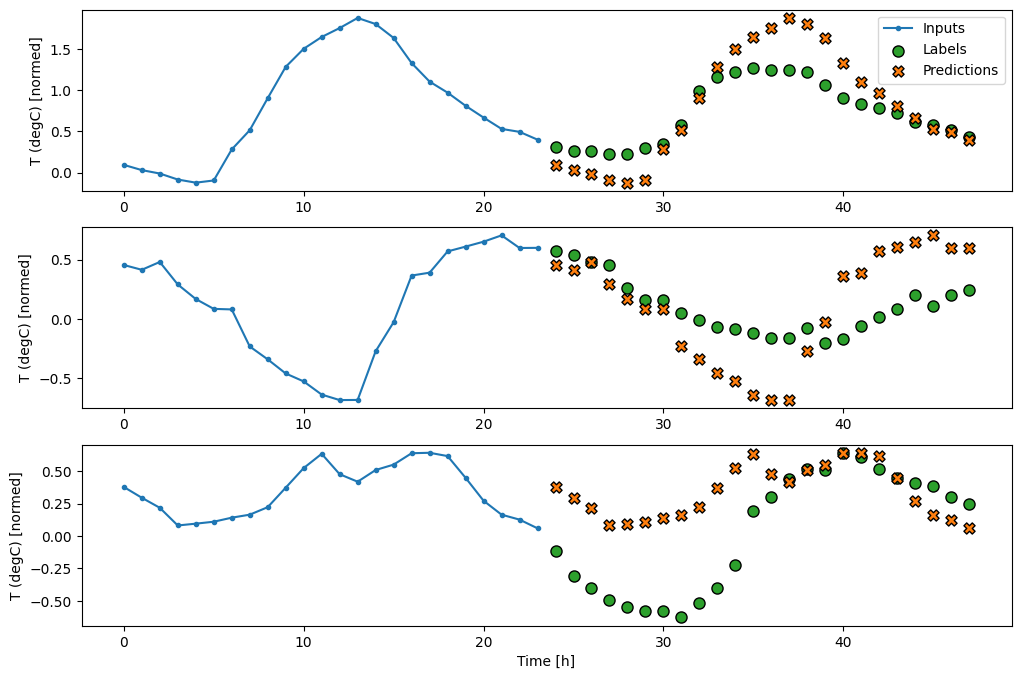

In [74]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

#### Linear

437/437 [==============================] - 3s 6ms/step - loss: 0.2560 - mean_absolute_error: 0.3057


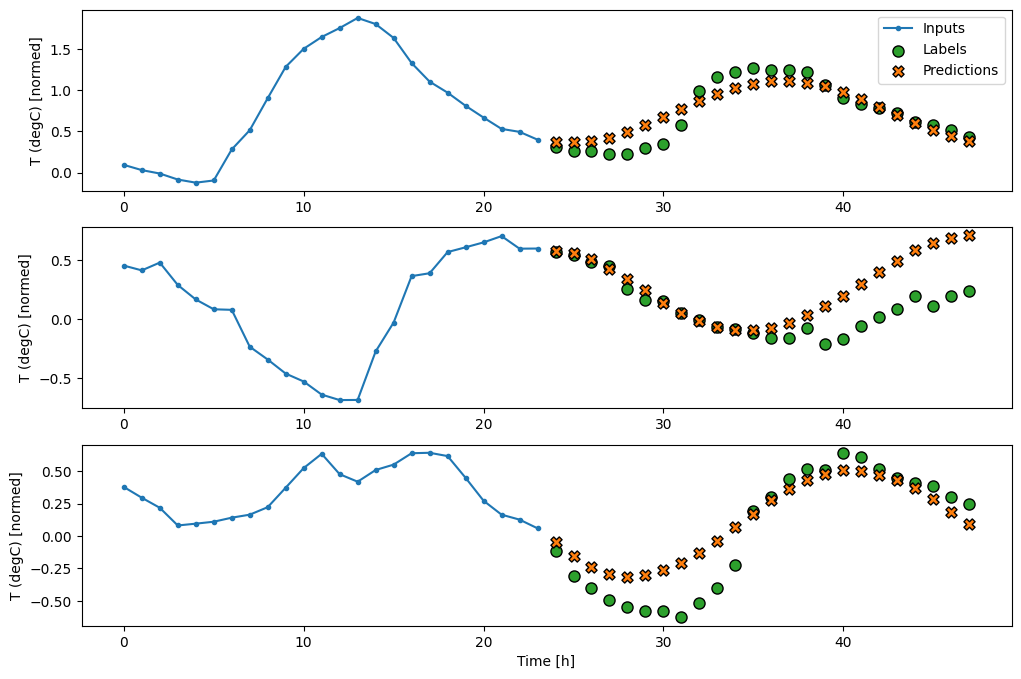

In [75]:
multi_linear_model = tf.keras.Sequential([
    # (batch, time, features)
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # (batch, 1, features)
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    # (batch, out_steps, features)
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

437/437 [==============================] - 3s 7ms/step - loss: 0.2195 - mean_absolute_error: 0.2827


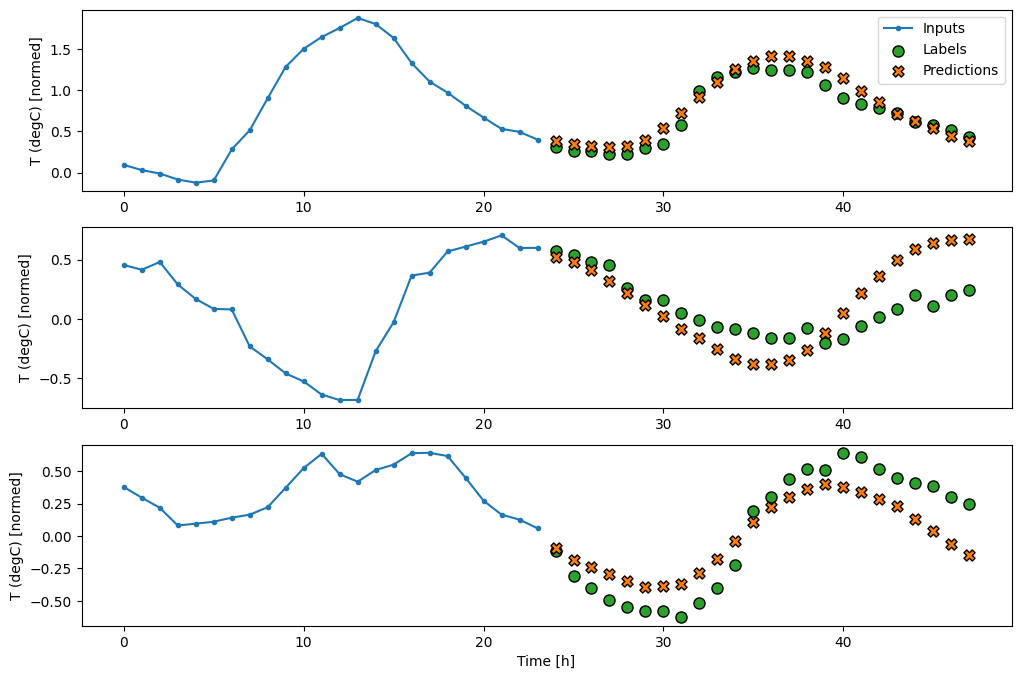

In [76]:
multi_dense_model = tf.keras.Sequential([
    # (batch, time, features)
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # (batch, 1, features)
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    # (batch, out_steps, features)
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

In [77]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # (batch, time, features)
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # (batch, CONV_WIDTH, features)
    tf.keras.layers.Conv1D(256, CONV_WIDTH, activation='relu'),
    # (batch, 1, 256)
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # (batch, 1,  out_steps*features)
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    # (batch, out_steps, features)
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/20
1532/1532 [==============================] - 17s 10ms/step - loss: 0.2385 - mean_absolute_error: 0.3046 - val_loss: 0.2235 - val_mean_absolute_error: 0.2884
Epoch 2/20
1532/1532 [==============================] - 15s 10ms/step - loss: 0.2194 - mean_absolute_error: 0.2857 - val_loss: 0.2230 - val_mean_absolute_error: 0.2879
Epoch 3/20
1532/1532 [==============================] - 35s 23ms/step - loss: 0.2160 - mean_absolute_error: 0.2829 - val_loss: 0.2188 - val_mean_absolute_error: 0.2843
Epoch 4/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.2128 - mean_absolute_error: 0.2799 - val_loss: 0.2178 - val_mean_absolute_error: 0.2838
Epoch 5/20
1532/1532 [==============================] - 15s 10ms/step - loss: 0.2108 - mean_absolute_error: 0.2784 - val_loss: 0.2149 - val_mean_absolute_error: 0.2818
Epoch 6/20
1532/1532 [==============================] - 16s 10ms/step - loss: 0.2089 - mean_absolute_error: 0.2768 - val_loss: 0.2147 - val_mean_absolute_error: 

KeyboardInterrupt: 

#### RNN

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # (batch, time, features)
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32),
    # (batch, lstm_units)
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # (batch, out_steps*features)
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    # (batch, out_steps, features)
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

#### RNN

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()